In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import pmdarima as pm
print(f"Using pmdarima {pm.__version__}")

Using pmdarima 2.0.4


<h3>Read the bitcoin price dataset into a Dataframe:</h3>

In [4]:
df = pd.read_csv(r'C:\Users\dre2\Desktop\personal docs\WGU\D214\D214\bitcoin_price\BTC-USD.csv')


In [5]:
df[df['Close'].isnull()].index.tolist()

[2919]

In [6]:
df = df[0:2919]
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2914,2022-09-23,19412.400391,19464.671875,18617.552734,19297.638672,19297.638672,3.889608e+10
2915,2022-09-24,19296.990234,19310.197266,18861.974609,18937.011719,18937.011719,2.614964e+10
2916,2022-09-25,18936.310547,19134.732422,18696.468750,18802.097656,18802.097656,2.335997e+10
2917,2022-09-26,18803.900391,19274.873047,18721.285156,19222.671875,19222.671875,4.414880e+10
2918,2022-09-27,19221.839844,20338.455078,18915.667969,19110.546875,19110.546875,5.857144e+10


<h3>Create training data and test data out of the daily close column</h3>

In [14]:
train_len = int(df.shape[0] * 0.8)
train_data, test_data = df[:train_len], df[train_len:]

y_train = train_data['Close'].values
y_test = test_data['Close'].values

print(f"{train_len} train samples")
print(f"{df.shape[0] - train_len} test samples")

2335 train samples
584 test samples


<h3>Call the function and pass in data</h3>

In [15]:
auto2 = pm.auto_arima(y_train, trace=True, maxiter=5,
                      seasonal=False, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=34876.155, Time=0.42 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=36450.197, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=35821.047, Time=0.13 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=34913.633, Time=0.23 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=36448.198, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=34895.107, Time=0.36 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=34943.883, Time=0.34 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=34883.424, Time=0.42 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=34866.149, Time=0.52 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=34887.303, Time=0.46 sec
 ARIMA(3,2,3)(0,0,0)[0] intercept   : AIC=34857.898, Time=0.58 sec
 ARIMA(4,2,3)(0,0,0)[0] intercept   : AIC=34866.594, Time=0.64 sec
 ARIMA(3,2,4)(0,0,0)[0] intercept   : AIC=34818.155, Time=0.81 sec
 ARIMA(2,2,4)(0,0,0)[0] intercept   : AIC=34830.070, Time=0.67 sec
 ARIMA(4,2,4)(0,0,0

In [16]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
from sklearn.metrics import mean_absolute_percentage_error

model = auto2

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)
    
    model.update(new_ob)

In [17]:
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})

<h3>Plot data</h3>

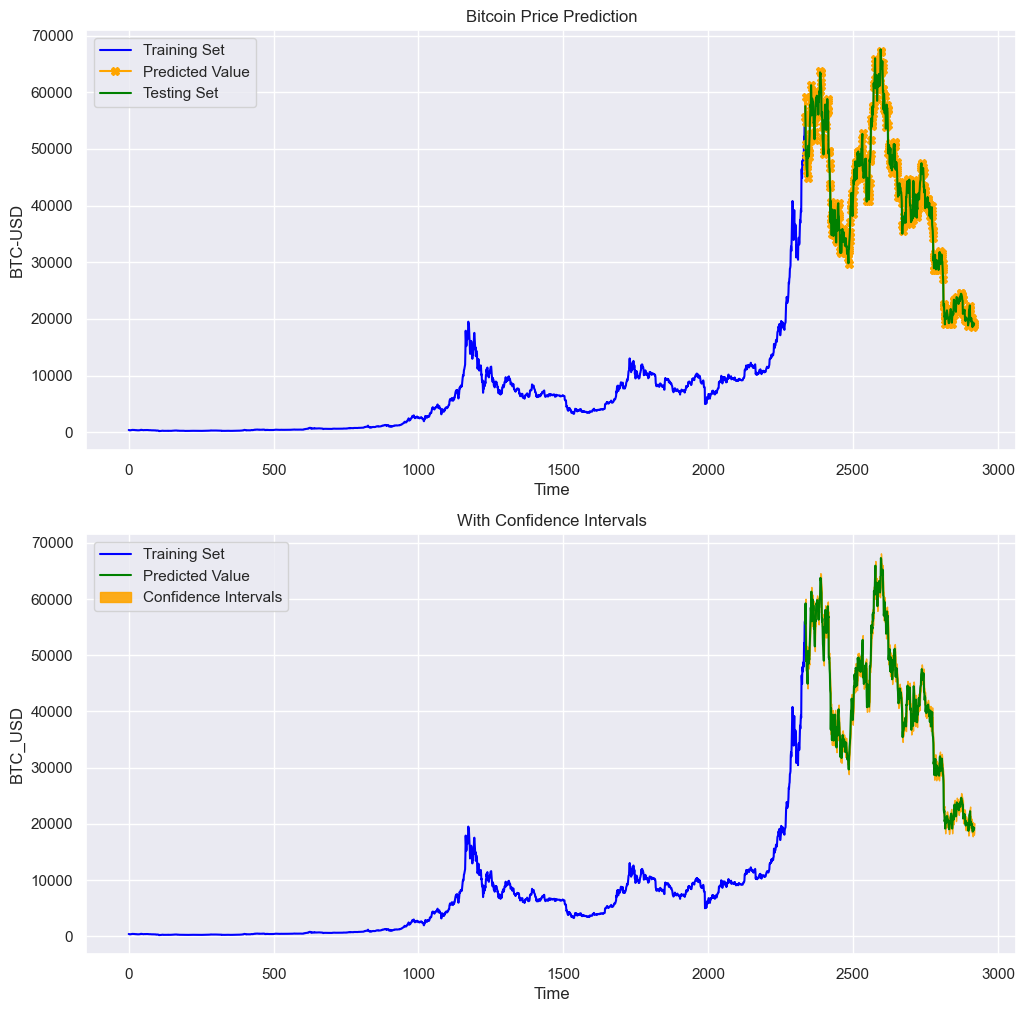

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# actual vs predicted 
axes[0].plot(y_train, color='blue', label='Training Set')
axes[0].plot(test_data.index, forecasts, color='orange', marker='X',
             label='Predicted Value')

axes[0].plot(test_data.index, y_test, color='green', label='Testing Set')
axes[0].set_title('Bitcoin Price Prediction')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('BTC-USD')

axes[0].legend()


# with confidence intervals
axes[1].plot(y_train, color='blue', label='Training Set')
axes[1].plot(test_data.index, forecasts, color='green',
             label='Predicted Value')

axes[1].set_title('With Confidence Intervals')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('BTC_USD')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test_data.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")


axes[1].legend()

<h3>Print accuracy metrics</h3>

In [19]:
print(f"Mean squared error: {mean_squared_error(y_test, forecasts)}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, forecasts)}")

Mean squared error: 2645093.3979591792
MAPE: 0.028445218095843453
